# SkimLit - NLP project

In [1]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git # get the data here
# !ls pubmed-rct

In [2]:
data_dir = 'PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt']

## Data Preprocessing

In [5]:
# Function to read the lines of a document
def get_lines(filename):
    with open(filename, 'r') as file:
        return file.readlines()
    
# Read in the training lines
train_lines = get_lines(data_dir + 'train.txt') 

In [6]:
def preprocess_text_with_lines(filename):
    input_lines = get_lines(filename)
    abstract_lines = "" # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = "" # Reset the abstract string if the line starts with '###'
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dictionary for each line
                target_text_split = abstract_line.split('\t') # Split target label from text
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower() # Get target text and lower it
                line_data['line_number'] = abstract_line_number # What number line does the line appear in the abstract?
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data) # Append line data to abstract samples list
        else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [7]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_lines(data_dir + 'train.txt')
val_samples = preprocess_text_with_lines(data_dir + 'dev.txt') 
test_samples = preprocess_text_with_lines(data_dir + 'test.txt')

In [8]:
# Turn the abstract lines into DataFrames
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [9]:
# Distribution of labels in the training data
train_df['target'].value_counts()

target
RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: count, dtype: int64

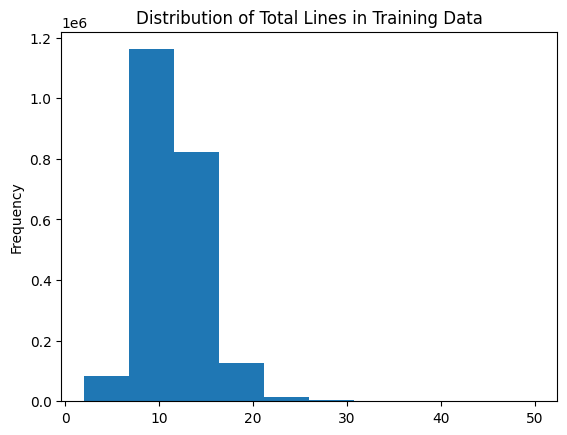

In [10]:
train_df.total_lines.plot.hist()
plt.title("Distribution of Total Lines in Training Data");

In [11]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [12]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

In [13]:
# Get class names and number of classes from LabelEncoder instance
class_names = one_hot_encoder.categories_[0]
num_classes = len(class_names)
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

### Character Embeddings

#### Creating a character-level tokenizer

In [14]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [15]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [16]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(147.82646377869133)

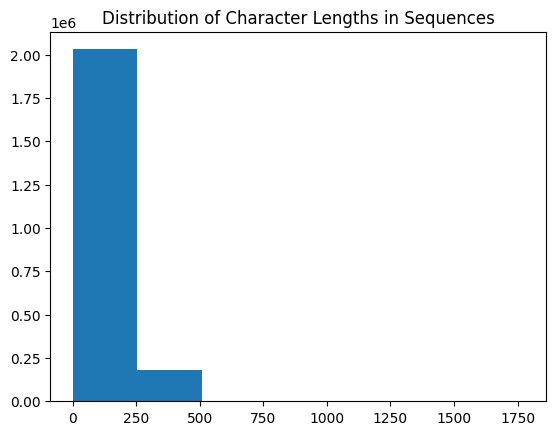

In [17]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)
plt.title("Distribution of Character Lengths in Sequences")
plt.show()

Most of our sequences are between 0 and 250 characters long, use percentile to figure out what length covers 95% of our sequences.

In [18]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

284

Now we know the sequence length which covers 95% of sequences, we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter.

In [19]:
# Get all keyboard characters for char-level embedding
import string
from tensorflow.keras.layers import TextVectorization
alphabet = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS, 
                                    output_sequence_length=output_seq_char_len, 
                                    name="char_vectorizer",
                                    standardize="lower_and_strip_punctuation") # None if you don't want punctuation removed
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Save the character vectorizer 
import pickle

with open('model_components/char_vectorizer.pkl', 'wb') as file:
  pickle.dump(char_vectorizer, file)

In [20]:
len(char_vectorizer.get_vocabulary())

28

#### Creating a character-level embedding

In [21]:
# Create char embedding layer
from tensorflow.keras.layers import Embedding
cahr_vocab = char_vectorizer.get_vocabulary()
char_embed = Embedding(input_dim=len(cahr_vocab),
                              output_dim = 25,
                              mask_zero = True,
                              name="char_embed")

### Create positional embeddings

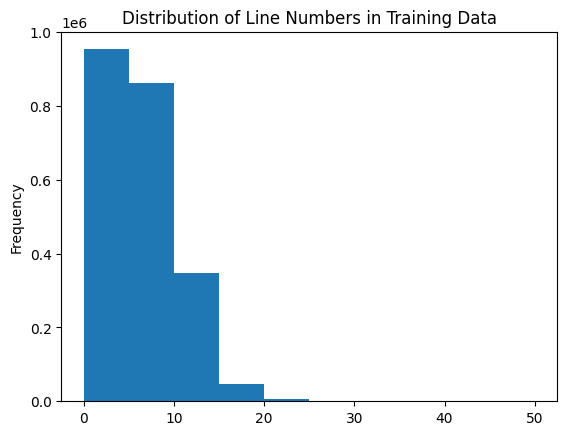

In [22]:
# Check the distribution of line numbers
train_df['line_number'].plot.hist()
plt.title("Distribution of Line Numbers in Training Data");

In [23]:
np.percentile(train_df['line_number'], 98)

np.float64(15.0)

In [24]:
# Create one-hot-encoded tensors of our line numbers
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

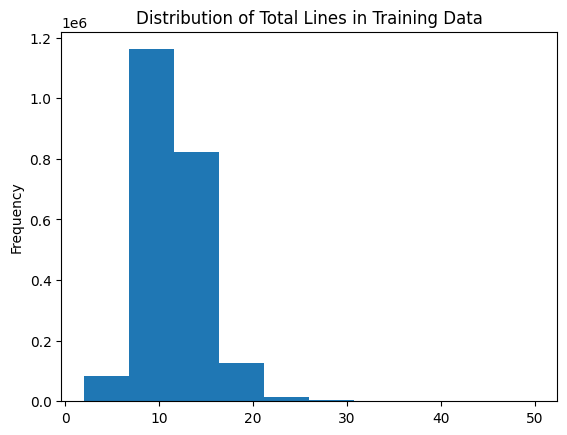

In [25]:
# Check the distribution of total lines
train_df['total_lines'].plot.hist()
plt.title("Distribution of Total Lines in Training Data");

In [26]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df['total_lines'], 98)

np.float64(20.0)

In [27]:
# Create one-hot-encoded tensors of our total lines
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

### Pretrainde token embedding USE

In [28]:
# Prepare Universal Sentence Encoder (USE)
from tensorflow.keras import Layer
import tensorflow_hub as hub 
# Path to the Universal Sentence Encoder model
path = "universal-sentence-encoder/2"
# Download USE here https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true
# Load the USE model from TensorFlow Hub
tf_hub_embedding_layer = hub.KerasLayer(path, input_shape=[], dtype=tf.string, trainable=False)

# Define a custom Keras Layer that uses the USE model for embedding
class Embedding(Layer):
    def call(self, x):
        return tf_hub_embedding_layer(x)

#### Building a tribrid embedding model
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a `tf.keras.Model`

In [29]:
from tensorflow.keras import layers
# Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = Embedding()(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM for sequence data
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# Setup line number inputs/model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_dense = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_dense)

# Setup total lines inputs/model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_dense)

# Combine token and char models into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])

hybrid_dense = layers.Dense(256, activation="relu")(combined_embeddings)
hybrid_dropout = layers.Dropout(0.5)(hybrid_dense)

# Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                                total_lines_model.output,
                                                                                combined_embeddings])

output_layer = layers.Dense(num_classes, activation="softmax")(tribrid_embeddings)

model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input], 
                                 outputs=output_layer,
                                 name="tribrid_embedding_model")

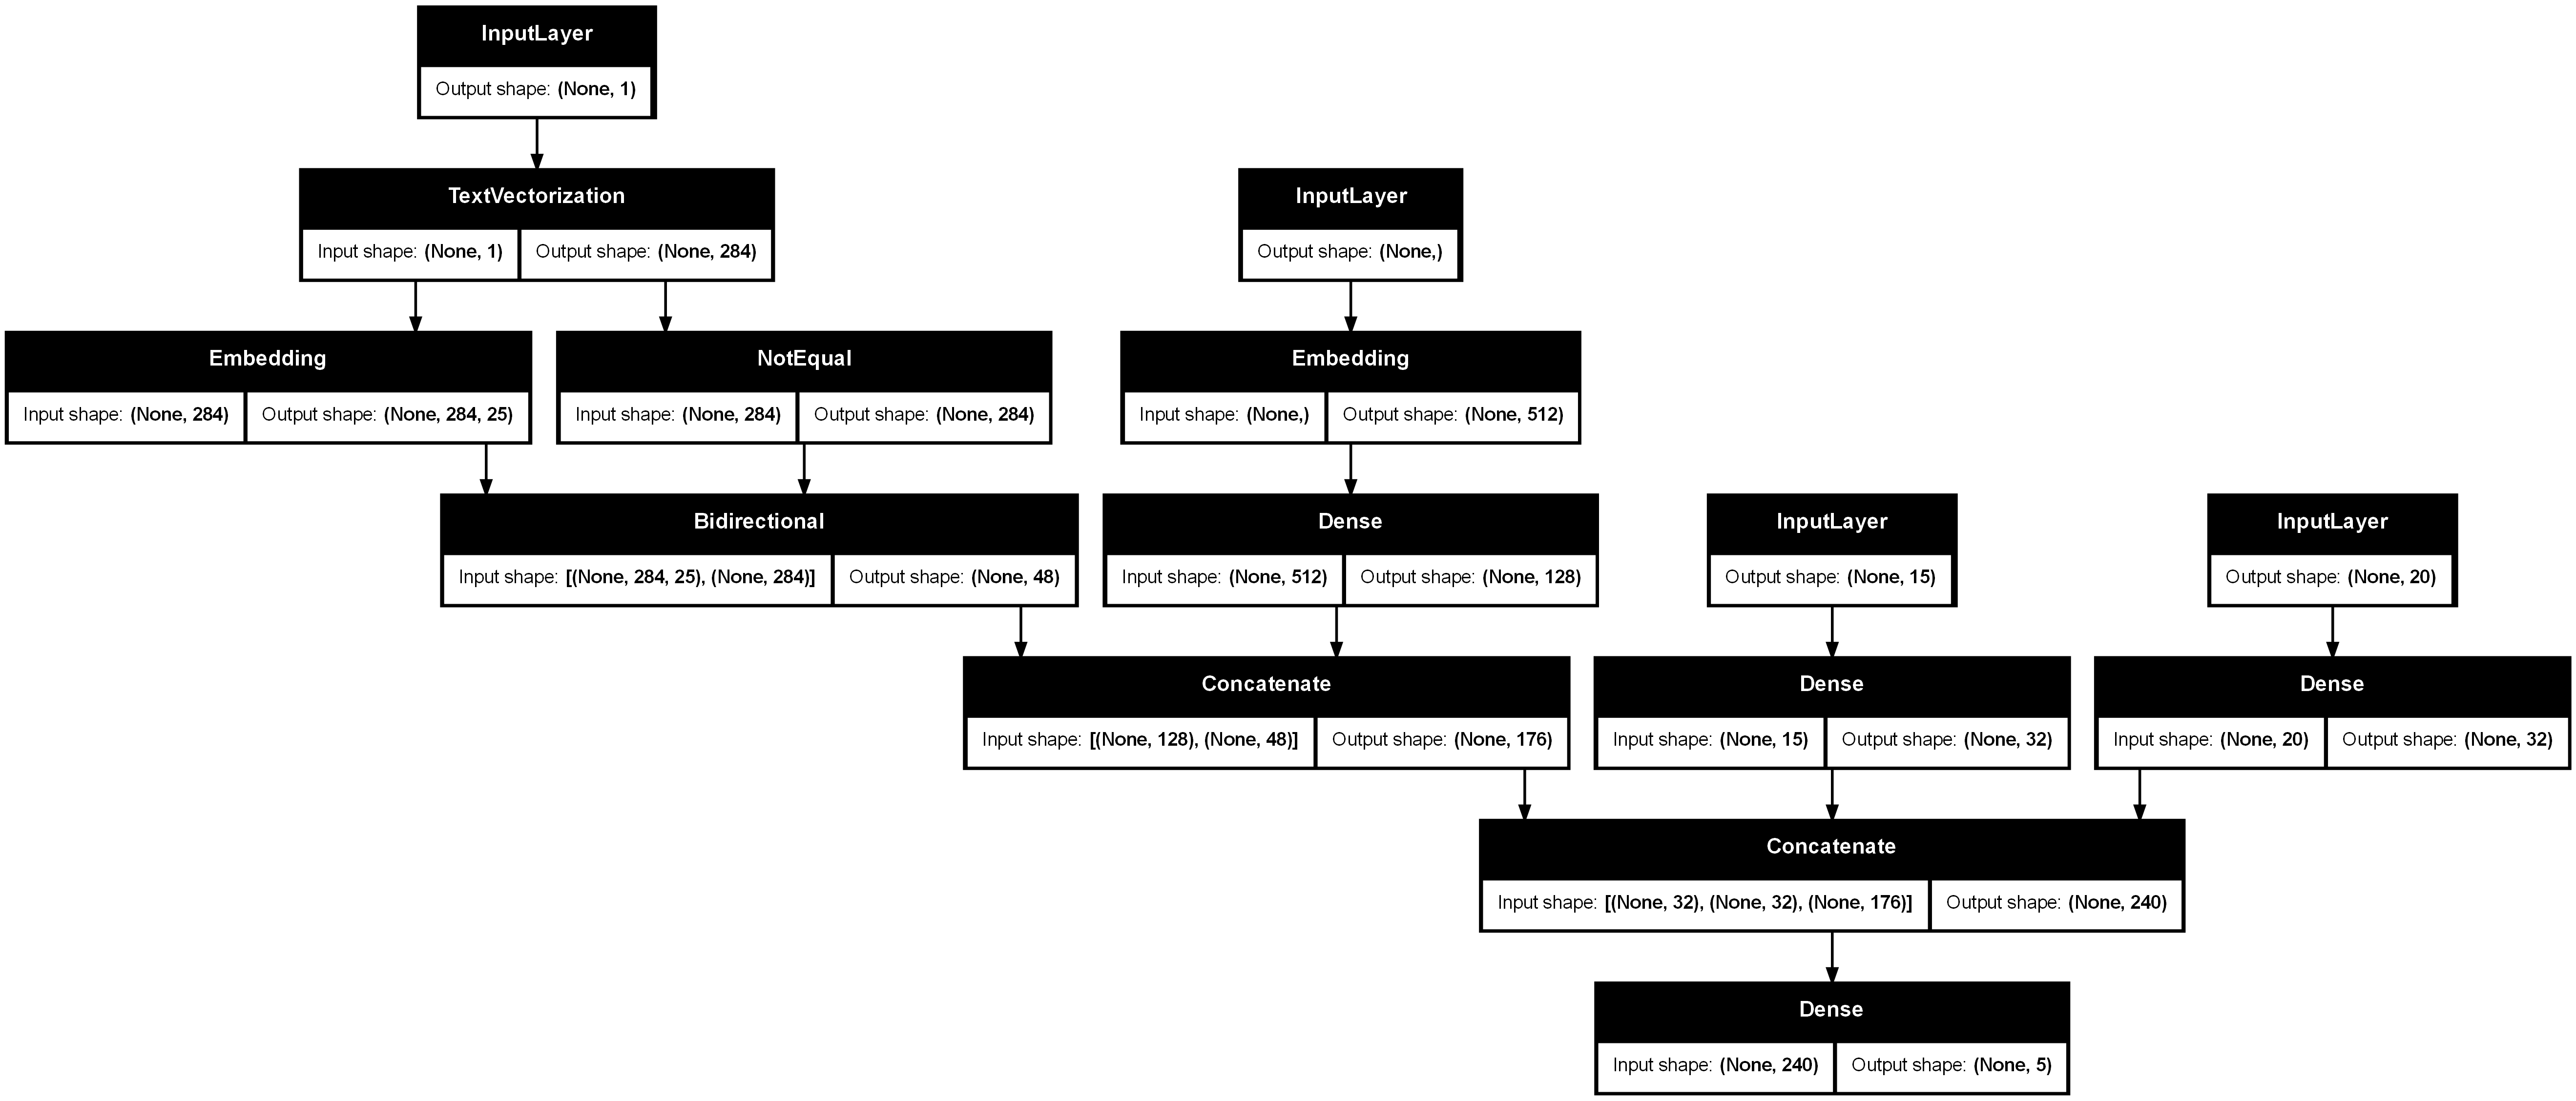

In [32]:
# Plot the tribid model
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [33]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

### Create tribrid embedding datasets and fit tribrid model

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)


In [34]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pod_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pod_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

valid_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
valid_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
valid_char_token_pos_dataset = tf.data.Dataset.zip((valid_char_token_pos_data, valid_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [35]:
# Fit the model
history_model = model.fit(train_char_token_pos_dataset,
                          steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                          epochs=3,
                          validation_data=valid_char_token_pos_dataset,
                          validation_steps=int(0.1 * len(valid_char_token_pos_dataset)))

Epoch 1/3


c:\Users\davyd\miniconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['line_number_input', 'total_lines_input', 'token_input', 'char_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


6912/6912 ━━━━━━━━━━━━━━━━━━━━ 1019s 146ms/step - accuracy: 0.7943 - loss: 0.9940 - val_accuracy: 0.8497 - val_loss: 0.9170
Epoch 2/3
6912/6912 ━━━━━━━━━━━━━━━━━━━━ 706s 102ms/step - accuracy: 0.8511 - loss: 0.9140 - val_accuracy: 0.8712 - val_loss: 0.8905
Epoch 3/3
6912/6912 ━━━━━━━━━━━━━━━━━━━━ 836s 121ms/step - accuracy: 0.8571 - loss: 0.9050 - val_accuracy: 0.8656 - val_loss: 0.8922


## Evaluate model on test data

In [73]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Function to calculate the metrics of a model
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [74]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

#### Metrics Assessment

In [77]:
# Encode the test labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_df["target"].to_numpy())  # Fit the label encoder with training data labels
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Save the label encoder
with open('model_components/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Make predictions on the test dataset
test_pred_probs = model.predict(test_pos_char_token_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)
calculate_results(y_true=test_labels_encoded,y_pred=test_preds)

922/922 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step


{'accuracy': 86.1763808361306,
 'precision': np.float64(0.8623725378381859),
 'recall': np.float64(0.8617638083613061),
 'f1': np.float64(0.8601254567511031)}

The model demonstrates strong overall performance with an accuracy of 86.18%

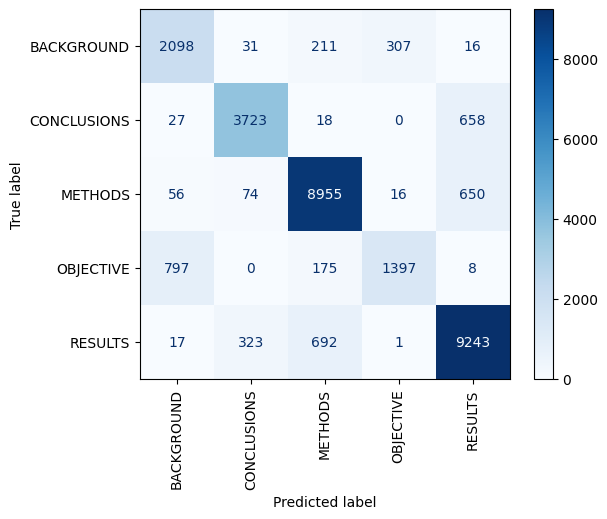

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_true=test_labels_encoded, y_pred=test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation="vertical");

**Notice**:
1. **High Accuracy for `RESULTS` and `METHODS`**:
    - The `RESULTS` class has the highest correct predictions (9236), followed closely by `METHODS` (9059).
    - This indicates that the model performs very well on these classes.
    - It can be noted that the model often misclassifies `METHODS` and `RESULTS` with each other.
2. **Significant Misclassification in `BACKGROUND` and `OBJECTIVE`**:
    - `BACKGROUND` and `OBJECTIVE` are often misclassified into each other.
3. **`CONCLUSIONS` Shows Lower Confusion**:
    - While not perfect, the `CONCLUSIONS` class has fewer misclassifications compared to `BACKGROUND` and `OBJECTIVE`, indicating relatively good performance.
    - There are also frequent misclassifications between `CONCLUSIONS` and `RESULTS`.

#### Find most wrong results

In [79]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head()

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,many pathogenic processes and diseases are the...,0,10,BACKGROUND,0.614927,True
1,BACKGROUND,it was recently demonstrated that supraphysiol...,1,10,BACKGROUND,0.532684,True
2,BACKGROUND,"in the present study , we examined the associa...",2,10,BACKGROUND,0.350186,True
3,BACKGROUND,"in addition , we compared plasma levels of map...",3,10,METHODS,0.428953,False
4,METHODS,a total of @ mi patients and @ control persons...,4,10,RESULTS,0.498825,False


In [80]:
# Find top 10 most wrong samples
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_10_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13897,RESULTS,"costs were assessed from a us perspective , an...",3,13,METHODS,0.949377,False
1728,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.935267,False
4859,RESULTS,the primary endpoint was seroconversion as mea...,5,12,METHODS,0.918848,False
23802,RESULTS,the following primary and outcome variables we...,3,8,METHODS,0.916391,False
7727,RESULTS,the control group received weekly on-site lect...,3,10,METHODS,0.915954,False
6185,METHODS,there were no significant differences between ...,7,11,RESULTS,0.914480,False
29424,METHODS,women who attended the workshop had higher sel...,7,9,RESULTS,0.906344,False
3424,BACKGROUND,faecal worm egg count was also measured .,3,11,METHODS,0.906218,False
25542,METHODS,this study provides class i evidence that trea...,10,10,CONCLUSIONS,0.903499,False
22266,OBJECTIVE,procedure this was a randomized ( @:@ ) contro...,4,14,METHODS,0.901034,False


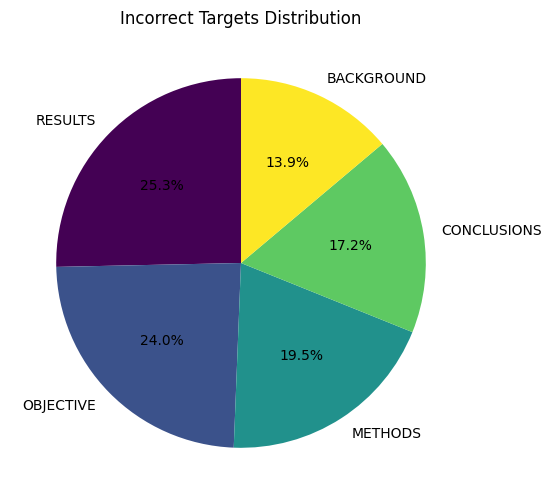

In [81]:
# Incorrect predictions distribution
import matplotlib.pyplot as plt
incorrect_predictions = test_df[test_df["correct"] == False]
incorrect_target_counts = incorrect_predictions["target"].value_counts()
plt.figure(figsize=(10, 6))
incorrect_target_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Incorrect Targets Distribution')
plt.ylabel('')
plt.show()

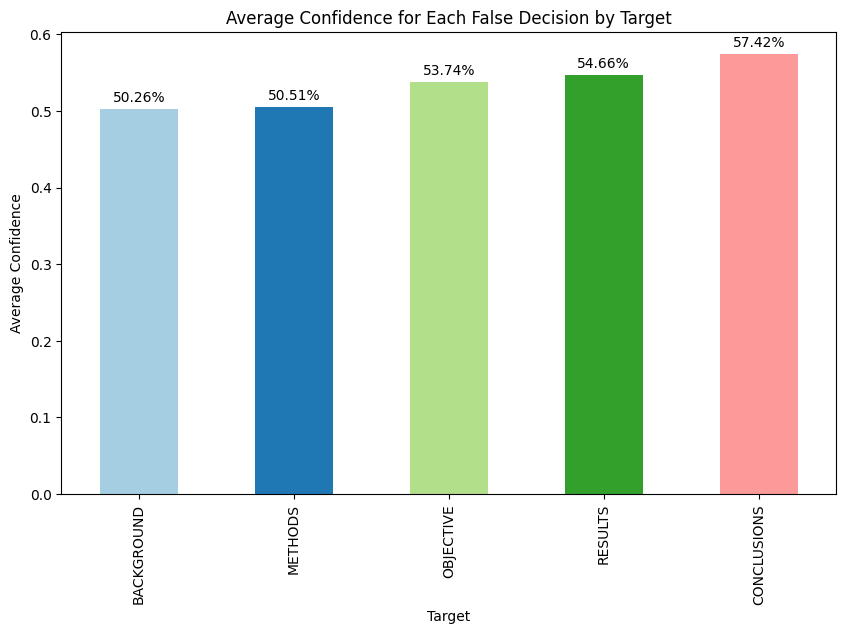

In [82]:
import matplotlib.pyplot as plt

# Calculate the average confidence for each false decision for target
false_predictions = test_df[~test_df["correct"]]
avg_confidence_per_target = false_predictions.groupby("target")["pred_prob"].mean()

# Sort the average confidence in ascending order
avg_confidence_per_target = avg_confidence_per_target.sort_values()

# Plot the average confidence for each false decision for target
ax = avg_confidence_per_target.plot(kind='bar', figsize=(10, 6), color=plt.cm.Paired(range(len(avg_confidence_per_target))), title="Average Confidence for Each False Decision by Target")
plt.xlabel("Target")
plt.ylabel("Average Confidence")

# Add percentages on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.show()

## Try model on example_abstracts

In [88]:
# Import the example abstracts
import json
with open("example_abstracts.json", "r") as f:
  abstracts = json.load(f)

# Create sentencizer
from spacy.lang.en import English
nlp = English() 
sentencizer = nlp.add_pipe("sentencizer") 
doc = nlp(abstracts[0]["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)] 
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [94]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [91]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 

# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

In [92]:
# Make predictions on sample abstract features
test_abstract_pred_probs = model.predict(x=(test_abstract_line_numbers_one_hot,
                                            test_abstract_total_lines_one_hot,
                                            tf.constant(abstract_lines),
                                            tf.constant(abstract_chars)))
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)

test_abstract_pred_classes = [one_hot_encoder.categories_[0][i] for i in test_abstract_preds]
test_abstract_pred_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [93]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


## Create a function to classify input sentences and test it

In [5]:
import tensorflow as tf
def calssify_abstract_sentences(example_sentence,model):
    # Split the sentence into lines
    abstract_lines = example_sentence.split('. ')
    # Remove any empty lines after splitting
    abstract_lines = [line.strip() for line in abstract_lines if line.strip()]
    
    # Get the total number of lines
    total_lines_in_sample = len(abstract_lines)

    # Create the list of dictionaries
    sample_lines = []
    for i, line in enumerate(abstract_lines):
        sample_dict = {
            "text": line,
            "line_number": i,
            "total_lines": total_lines_in_sample - 1
        }
        sample_lines.append(sample_dict)

    # Get all line_number values from sample abstract
    test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
    # One-hot encode to same depth as training data, so model accepts right input shape
    test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
    
    # Get all total_lines values from sample abstract
    test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
    # One-hot encode to same depth as training data, so model accepts right input shape
    test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

    # Function to split sentences into characters
    def split_chars(text):
        return " ".join(list(text))

    # Split abstract lines into characters
    abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

    # Make predictions on sample abstract features
    test_abstract_pred_probs = model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
    
    # Turn prediction probabilities into prediction classes
    test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)

    # Load the label encoder
    with open('model_components/label_encoder.pkl', 'rb') as file:
        label_encoder = pickle.load(file)
    
    # Turn prediction class integers into string class names
    test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]

    # Visualize abstract lines and predicted sequence labels
    output = []
    for i, line in enumerate(abstract_lines):
        output.append(f"{test_abstract_pred_classes[i]}: {line}")
    return output


In [143]:
example_sentence = "This study investigated the impact of a mindfulness-based intervention on anxiety levels in adults. Participants were assigned to either the intervention group or a control group. The intervention consisted of weekly mindfulness sessions, daily practice routines, and mindfulness exercises to enhance stress management and emotional well-being. A structured feedback system was used to monitor progress and provide personalized recommendations. Significant reductions in anxiety were observed in the intervention group compared to the control group. Self-reported measures indicated improved mood and increased resilience among participants. High levels of program satisfaction were reported, with participants valuing the supportive and non-judgmental environment. Effect sizes for anxiety reduction were medium to large, favoring the mindfulness-based intervention."
calssify_abstract_sentences(example_sentence,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


['OBJECTIVE: This study investigated the impact of a mindfulness-based intervention on anxiety levels in adults',
 'METHODS: Participants were assigned to either the intervention group or a control group',
 'METHODS: The intervention consisted of weekly mindfulness sessions, daily practice routines, and mindfulness exercises to enhance stress management and emotional well-being',
 'METHODS: A structured feedback system was used to monitor progress and provide personalized recommendations',
 'RESULTS: Significant reductions in anxiety were observed in the intervention group compared to the control group',
 'RESULTS: Self-reported measures indicated improved mood and increased resilience among participants',
 'RESULTS: High levels of program satisfaction were reported, with participants valuing the supportive and non-judgmental environment',
 'RESULTS: Effect sizes for anxiety reduction were medium to large, favoring the mindfulness-based intervention.']

## Save the model

In [ ]:
model.save("model_components/final_model.keras")

## Load model with custom objects

In [4]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
import tensorflow_hub as hub

# Load the saved char_vectorizer state
with open("model_components/char_vectorizer.pkl", "rb") as f:
    char_vectorizer = pickle.load(f)

# Verify the char_vectorizer is loaded correctly
print("char_vectorizer loaded:", char_vectorizer)

# Define the custom Embedding Layer
path = "universal-sentence-encoder/2"
tf_hub_embedding_layer = hub.KerasLayer(path, input_shape=[], dtype=tf.string, trainable=False)
# Download USE here https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true

class Embedding(Layer):
    def call(self, x):
        return tf_hub_embedding_layer(x)

# Load the final model with custom objects
final_model_path = "model_components/final_model.keras"
final_model = load_model(
    final_model_path,
    custom_objects={
        "TextVectorization": char_vectorizer,  # Use the loaded char_vectorizer
        "Embedding": Embedding,
        "KerasLayer": hub.KerasLayer  # Ensure the USE layer is recognized
    }
)

char_vectorizer loaded: <TextVectorization name=char_vectorizer, built=False>


### Experiment loaded model

In [7]:
example_sentence = "This study investigated the impact of a mindfulness-based intervention on anxiety levels in adults. Participants were assigned to either the intervention group or a control group. The intervention consisted of weekly mindfulness sessions, daily practice routines, and mindfulness exercises to enhance stress management and emotional well-being. A structured feedback system was used to monitor progress and provide personalized recommendations. Significant reductions in anxiety were observed in the intervention group compared to the control group. Self-reported measures indicated improved mood and increased resilience among participants. High levels of program satisfaction were reported, with participants valuing the supportive and non-judgmental environment. Effect sizes for anxiety reduction were medium to large, favoring the mindfulness-based intervention."
calssify_abstract_sentences(example_sentence,final_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


['OBJECTIVE: This study investigated the impact of a mindfulness-based intervention on anxiety levels in adults',
 'METHODS: Participants were assigned to either the intervention group or a control group',
 'METHODS: The intervention consisted of weekly mindfulness sessions, daily practice routines, and mindfulness exercises to enhance stress management and emotional well-being',
 'METHODS: A structured feedback system was used to monitor progress and provide personalized recommendations',
 'RESULTS: Significant reductions in anxiety were observed in the intervention group compared to the control group',
 'RESULTS: Self-reported measures indicated improved mood and increased resilience among participants',
 'RESULTS: High levels of program satisfaction were reported, with participants valuing the supportive and non-judgmental environment',
 'RESULTS: Effect sizes for anxiety reduction were medium to large, favoring the mindfulness-based intervention.']